# March Madness 2019 Predictions  

### Made using logistic regression and Dean Oliver's four factors (plus seeding)

The four factors are:
1. Shooting
2. Turnovers
3. Rebounding
4. Free throws

In a little more detail:
1. Effective field goal percentage (eFGP), which weights 3-point shots more than 2-pointers.  
eFGP = [FG + 0.5*(three-point FG)] / (FG attempts)  

2. Turnover rate (TOR) = turnovers / [FG attempts + (0.44*FT attempts) + turnovers]  
  
3. Offensive Rebounding Percentage (ORP) = (offensive rebounds) / [(offensive rebounds) + (opponent's defensive rebounds)]  
  
4. Free throw rate (FTR) = FT / (FG attempts)

For unseeded teams, I set their seed to 17, so it is lower than all the seeded teams, but does not differentiate further among them.

### Table of contents (click to jump to a section)
[Load and prepare the data](#Step1)  
[Select the training data](#Step2)  
[Select the test data](#Step3)  
[Select and train the model](#Step4)  
[Make predictions](#Step5)  
[Load in the results for 2019 thus far](#Step6)  
[Get accuracy of predictions](#Step7)  
[Fill out visual bracket based on predictions](#Step8)

In [1]:
# import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import scikit-learn packages
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

In [2]:
# turn off chained assignment warning
pd.set_option('mode.chained_assignment', None)

<a name='Step1'></a>

### Load and prepare the data

In [3]:
# alias for the folder with the given data
datadir = 'mens-machine-learning-competition-2019/Stage2DataFiles/'

# load in the necessary files
confs              = pd.read_csv(datadir + 'Conferences.csv')
tourney_results_c  = pd.read_csv(datadir + 'NCAATourneyCompactResults.csv')
tourney_results_d  = pd.read_csv(datadir + 'NCAATourneyDetailedResults.csv')
tourney_seed_slots = pd.read_csv(datadir + 'NCAATourneySeedRoundSlots.csv')
tourney_seeds      = pd.read_csv(datadir + 'NCAATourneySeeds.csv')
tourney_slots      = pd.read_csv(datadir + 'NCAATourneySlots.csv')
season_results_c   = pd.read_csv(datadir + 'RegularSeasonCompactResults.csv')
season_results_d   = pd.read_csv(datadir + 'RegularSeasonDetailedResults.csv')
team_confs         = pd.read_csv(datadir + 'TeamConferences.csv')
teams              = pd.read_csv(datadir + 'Teams.csv')

In [4]:
# look at the structure of the data
season_results_d.head(2)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16


In [5]:
# make a list of the columns needed
fourfeat_prelist = ['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore',
                 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WTO',
                 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LTO']

# put results with those columns into a new df (first merging regular and tourney games)
df = pd.merge(season_results_d[fourfeat_prelist],
             tourney_results_d[fourfeat_prelist], how='outer')

In [6]:
# calculate the four factors for both teams
df['WeFGP'] = (df['WFGM'] + 0.5*df['WFGM3']) / df['WFGA']
df['LeFGP'] = (df['LFGM'] + 0.5*df['LFGM3']) / df['LFGA']
df['WTOR'] = df['WTO'] / (df['WFGA'] + (0.44*df['WFTA']) + df['WTO'])
df['LTOR'] = df['LTO'] / (df['LFGA'] + (0.44*df['LFTA']) + df['LTO'])
df['WORP'] = df['WOR'] / (df['WOR'] + df['LDR'])
df['LORP'] = df['LOR'] / (df['LOR'] + df['WDR'])
df['WFTR'] = df['WFTM'] / df['WFGA']
df['LFTR'] = df['LFTM'] / df['LFGA']

In [7]:
# now put those factors into a new df (to keep things clean, and not have lots of columns)
fourfeat_list = ['Season', 'DayNum', 'WTeamID', 'LTeamID',
                'WeFGP', 'WTOR', 'WORP', 'WFTR',
                'LeFGP', 'LTOR', 'LORP', 'LFTR']
fourfeat_df = df[fourfeat_list]

In [8]:
# add conference abbreviations
fourfeat_df1 = fourfeat_df.merge(team_confs, left_on=['Season', 'WTeamID'],
                                 right_on=['Season', 'TeamID']).rename(columns={'ConfAbbrev':'WConfAbbrev'})
fourfeat_df2 = fourfeat_df1.merge(team_confs, left_on=['Season', 'LTeamID'],
                                  right_on=['Season', 'TeamID']).rename(columns={'ConfAbbrev':'LConfAbbrev'})

# drop the extra TeamID columns
fourfeat_df2.drop(['TeamID_x', 'TeamID_y'], axis='columns', inplace=True)

fourfeat_df2.head(2)

,Season,DayNum,WTeamID,LTeamID,WeFGP,WTOR,WORP,WFTR,LeFGP,LTOR,LORP,LFTR,WConfAbbrev,LConfAbbrev
0,2003,10,1104,1328,0.491379,0.258659,0.388889,0.189655,0.433962,0.223104,0.294118,0.301887,sec,big_twelve
1,2003,98,1400,1328,0.429688,0.120773,0.418605,0.187500,0.490385,0.192837,0.272727,0.192308,big_twelve,big_twelve


In [9]:
### add seeds

# get the seeds and convert from strings to ints
tourney_seeds2003 = tourney_seeds[tourney_seeds['Season'] >= 2003]
tourney_seeds2003['seed'] = tourney_seeds['Seed'].map(lambda x: x[1:3]).astype(int)

# join the winners' seed numbers to fourfeat_df2
fourfeat_df3 = fourfeat_df2.merge(tourney_seeds2003[['Season', 'TeamID', 'seed']],
                                 left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='outer')
fourfeat_df3.rename(columns={'seed':'Wseed'}, inplace=True)
fourfeat_df3.drop('TeamID', axis='columns', inplace=True)

# join the losers' seed numbers to fourfeat_df3
fourfeat_df4 = fourfeat_df3.merge(tourney_seeds2003[['Season', 'TeamID', 'seed']],
                                 left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='outer')
fourfeat_df4.rename(columns={'seed':'Lseed'}, inplace=True)
fourfeat_df4.drop('TeamID', axis='columns', inplace=True)

# set seed to 17 for non-seeded teams
fourfeat_df4.fillna(17, inplace=True)

# convert seeds from floats to ints
fourfeat_df4[['Wseed', 'Lseed']] = fourfeat_df4[['Wseed', 'Lseed']].astype(int)

In [10]:
# now that I have the features ready for the winning and losing teams,
# let's get the differences in these features, which is what we will use for modeling
deltas = ['seed_delta', 'eFGP_delta', 'TOR_delta', 'ORP_delta', 'FTR_delta']
feats  = ['seed',   'eFGP',  'TOR',  'ORP',  'FTR']
Wfeats = ['Wseed', 'WeFGP', 'WTOR', 'WORP', 'WFTR']
Lfeats = ['Lseed', 'LeFGP', 'LTOR', 'LORP', 'LFTR']

for delta, Wfeat, Lfeat in zip(deltas, Wfeats, Lfeats):
    fourfeat_df4[delta] = fourfeat_df4[Wfeat] - fourfeat_df4[Lfeat]

In [11]:
# I want each row to contain information about just one team, instead of one game
# so, make dfs for the winning and losing teams, and combine them
# so that final df will have each game twice

Wnames   = ['Season', 'DayNum', 'WTeamID']
Lnames   = ['Season', 'DayNum', 'LTeamID']
Newnames = ['Season', 'DayNum', 'TeamID']

df_wins   = pd.DataFrame()
df_losses = pd.DataFrame()

df_wins[Newnames + feats + deltas]   = fourfeat_df4[Wnames + Wfeats + deltas]
df_losses[Newnames + feats] = fourfeat_df4[Lnames + Lfeats]
df_losses[deltas]  = -fourfeat_df4[deltas]

df_wins['result']   = 1
df_losses['result'] = 0

df_all = pd.concat((df_wins, df_losses)).sort_values(['Season', 'DayNum'])
df_all.head(3)

,Season,DayNum,TeamID,seed,eFGP,TOR,ORP,FTR,seed_delta,eFGP_delta,TOR_delta,ORP_delta,FTR_delta,result
0,2003,10,1104,10,0.491379,0.258659,0.388889,0.189655,9.0,0.057417,0.035556,0.094771,-0.112232,1
3072,2003,10,1272,7,0.483871,0.155950,0.375000,0.161290,4.0,0.080886,0.019276,-0.041667,0.026962,1
0,2003,10,1328,1,0.433962,0.223104,0.294118,0.301887,-9.0,-0.057417,-0.035556,-0.094771,0.112232,0


<a name='Step2'></a>

### Select the training data

In [12]:
## define the training data (through the end of the regular season for each year, day 133)
## then shuffle it

# create a dictionary with df_all keyed by year
through_reg = {}
for year in range(2014, 2020):
    through_reg[year] = df_all[(df_all['Season'] < year) |
                        ((df_all['Season'] == year) & (df_all['DayNum'] < 133))]
    
# create dictionaries to hold X and y for each year
X_train = {}
y_train = {}

# loop through the years
for year in range(2014, 2020):
    X_train[year] = through_reg[year][deltas].values
    y_train[year] = through_reg[year]['result'].values
    
# shuffle X at the same time as y
for year in range(2014, 2020):
    X_train[year], y_train[year] = shuffle(X_train[year], y_train[year])

<a name='Step3'></a>

### Select the test data
To make predictions, I'm going to use the each team's regular season average for each feature for that year. (Except for seed, which will be the same throughout the season).

In [13]:
# create a dictionary with regular season games from df_all, keyed by year
df_reg = {}
for year in range(2014, 2020):
    df_reg[year] = df_all[((df_all['Season'] == year) & (df_all['DayNum'] < 133))]

# save the averages to a new df: df_avg
df_avg = {}
for year in range(2014, 2020):
    df_avg[year] = df_reg[year].groupby('TeamID')[feats].mean().reset_index().sort_values(['TeamID'])

In [14]:
# create a fcn to make a df for each possible matchup for a given season
# TODO: redo this in a more efficient way
def matchmaker(season_id):
    
    matchups_df = pd.DataFrame()
    matchup_ids = []
    team1_ids = []
    team2_ids = []
    nteams = len(teams)

    for i in range(nteams):
        for j in range(i+1,nteams):
            team1 = str(teams['TeamID'][i])
            team2 = str(teams['TeamID'][j])
            match_id = str(season_id) + '_' + team1+ '_' +team2
            matchup_ids.append(match_id)
            team1_ids.append(team1)
            team2_ids.append(team2)
    matchups_df['Match_ID'] = matchup_ids
    matchups_df['Season'] = pd.to_numeric(season_id)
    matchups_df['Team1']  = pd.to_numeric(team1_ids)
    matchups_df['Team2']  = pd.to_numeric(team2_ids)
    return matchups_df

In [15]:
# create matchups for each test season
matchups = {}
for year in range(2014, 2020):
    matchups[year] = matchmaker(year)

In [16]:
# now that we have all possible matchups for each season, let's add the average
# features for each team to that df

feats_t1 = ['seed1', 'eFGP1', 'TOR1', 'ORP1', 'FTR1']
feats_t2 = ['seed2', 'eFGP2', 'TOR2', 'ORP2', 'FTR2']

for year in range(2014, 2020):
    # merge for team 1 (and drop the duplicate TeamID)
    matchups[year] = matchups[year].merge(df_avg[year], how='inner', left_on='Team1', right_on='TeamID').drop(['TeamID'], axis='columns')
    # rename the features to indicate they're for Team1
    matchups[year] = matchups[year].rename(columns=dict(zip(feats,feats_t1)))
    
    # merge for team 2 (and drop the duplicate TeamID)
    matchups[year] = matchups[year].merge(df_avg[year], how='inner', left_on='Team2', right_on='TeamID').drop(['TeamID'], axis='columns')
    # rename the features to indicate they're for Team2
    matchups[year] = matchups[year].rename(columns=dict(zip(feats,feats_t2)))

In [17]:
matchups[2014].head()

,Match_ID,Season,Team1,Team2,seed1,eFGP1,TOR1,ORP1,FTR1,seed2,eFGP2,TOR2,ORP2,FTR2
0,2014_1101_1102,2014,1101,1102,17,0.477594,0.203911,0.246784,0.324772,17,0.500448,0.182794,0.261099,0.264238
1,2014_1101_1103,2014,1101,1103,17,0.477594,0.203911,0.246784,0.324772,17,0.498248,0.170383,0.349037,0.257723
2,2014_1102_1103,2014,1102,1103,17,0.500448,0.182794,0.261099,0.264238,17,0.498248,0.170383,0.349037,0.257723
3,2014_1101_1104,2014,1101,1104,17,0.477594,0.203911,0.246784,0.324772,17,0.496392,0.160064,0.296062,0.305219
4,2014_1102_1104,2014,1102,1104,17,0.500448,0.182794,0.261099,0.264238,17,0.496392,0.160064,0.296062,0.305219


In [18]:
# calculate the differences in the averages for the matchups
# and add a column for predictions, defaulted to 0.5

for year in range(2014, 2020):
    for i,j,k in zip(deltas, feats_t1, feats_t2):
        matchups[year][i] = 0
        matchups[year][i] = matchups[year][j] - matchups[year][k]
    # drop the non-delta features
    matchups[year].drop(feats_t1+feats_t2, axis='columns', inplace=True)
    #add the predictions column
    matchups[year]['pred'] = 0.5

In [19]:
# create standard Match_IDs for the tourneys, so results can be added to matchups
tourney_filter = {}
tourney_results = {}
for year in range(2014, 2020):
    tourney_filter[year] = ((tourney_results_c['Season'] == year) & (tourney_results_c['DayNum'] > 132))
    tourney_results[year] = tourney_results_c[tourney_filter[year]][['Season', 'WTeamID', 'LTeamID']]
    # create columns for the result and Match_ID
    tourney_results[year]['result'] = np.nan
    tourney_results[year]['Match_ID'] = None

tourney_results[2014].head(2)

,Season,WTeamID,LTeamID,result,Match_ID
1849,2014,1107,1291,NaN,None
1850,2014,1301,1462,NaN,None


In [20]:
# add results, from the point of view of the team with the lower TeamID
# 1 means they won, 0 means they lost

for year in range(2014, 2019):
    for i in range(len(tourney_results[year])):
        if tourney_results[year].iloc[i,1] < tourney_results[year].iloc[i,2]:
            tourney_results[year].iloc[i,3] = 1
            tourney_results[year].iloc[i,4] = str(year) + '_' + str(tourney_results[year].iloc[i,1]) + '_' + str(tourney_results[year].iloc[i,2])
        else:
            tourney_results[year].iloc[i,3] = 0
            tourney_results[year].iloc[i,4] = str(year) + '_' + str(tourney_results[year].iloc[i,2]) + '_' + str(tourney_results[year].iloc[i,1])
    # drop unnecessary rows
    tourney_results[year].drop(['Season', 'WTeamID', 'LTeamID'], axis='columns', inplace=True)

In [21]:
# since 2019 tourney results aren't available yet, but we know the teams playing,
# create a fcn to take the list of teams and create matchups between them
# (so we only have ~2,000 matchups instead of ~68,000)

# modify the matchmaker fcn to only include teams in a list (the ones in the tourney)
def matchmaker_tourney(season_id, tourney_teams):
    
    matchups_df = pd.DataFrame()
    matchup_ids = []
    team1_ids = []
    team2_ids = []
    nteams = len(tourney_teams)

    for i in range(nteams):
        for j in range(i+1,nteams):
            team1 = str(tourney_teams[i])
            team2 = str(tourney_teams[j])
            match_id = str(season_id) + '_' + team1+ '_' +team2
            matchup_ids.append(match_id)
            team1_ids.append(team1)
            team2_ids.append(team2)
    matchups_df['Match_ID'] = matchup_ids
    return matchups_df

In [22]:
# create the possible 2019 tourney matchups
tourney_teams_2019 = [1181, 1295, 1433, 1416, 1280, 1251, 1439, 1387, 1268, 1125,
                     1261, 1463, 1257, 1278, 1277, 1133, 1211, 1192, 1393, 1124,
                     1266, 1293, 1199, 1436, 1138, 1113, 1403, 1297, 1305, 1196,
                     1276, 1285, 1438, 1205, 1279, 1328, 1458, 1332, 1243, 1414,
                     1437, 1388, 1345, 1330, 1153, 1234, 1397, 1159, 1314, 1233,
                     1429, 1449, 1120, 1308, 1242, 1318, 1235, 1326, 1222, 1209,
                     1459, 1371, 1246, 1101, 1341, 1396, 1300, 1385]
tourney_teams_2019 = sorted(tourney_teams_2019)

tourney_results[2019] = matchmaker_tourney(2019, tourney_teams_2019)

In [23]:
# join the tourney results with the matchups
tourney = {}
for year in range(2014, 2020):
    tourney[year] = matchups[year].merge(tourney_results[year], how='inner')
    
# tourney[2019] should be just like the others, but without results
tourney[2019]['result'] = np.nan
tourney[2019].tail(2)

,Match_ID,Season,Team1,Team2,seed_delta,eFGP_delta,TOR_delta,ORP_delta,FTR_delta,pred,result
2276,2019_1458_1463,2019,1458,1463,-9,-0.045026,-0.031916,-0.017498,-0.044997,0.5,NaN
2277,2019_1459_1463,2019,1459,1463,-7,0.017136,-0.018354,0.063893,-0.025001,0.5,NaN


In [24]:
# select the test data for each year
X_test = {}
y_test = {}
for year in range(2014, 2020):
    X_test[year] = tourney[year][deltas].values
    y_test[year] = tourney[year]['result'].values


<a name='Step4'></a>

### Select and train the model

In [25]:
# train logistic regression models on data up through the regular season before
# that year's tournament. I don't think I should use games in 2016, say, to train a model
# to predict the 2014 tournament. I should probably still do some cross-validation.
model = {}
for year in range(2014, 2020):
    model[year] = LogisticRegression(penalty='l2', C=0.01)

In [26]:
# normalize the data
scalers = {}
for year in range(2014, 2020):
    scalers[year] = preprocessing.Normalizer().fit(X_train[year])
    X_train[year] = scalers[year].transform(X_train[year])
    X_test[year]  = scalers[year].transform(X_test[year])

In [27]:
# fit the models
for year in range(2014, 2020):
        model[year].fit(X_train[year], y_train[year])

<a name='Step5'></a>

### Make predictions

In [28]:
# predict, clip to between 5% and 95% confidence, and store the predictions
y_pred = {}
for year in range(2014, 2020):
    y_pred[year] = model[year].predict_proba(X_test[year])
    y_pred[year] = np.clip(y_pred[year], 0.05, 0.95)
    tourney[year]['pred'] = y_pred[year][:,1]

In [29]:
tourney[2014].head()

,Match_ID,Season,Team1,Team2,seed_delta,eFGP_delta,TOR_delta,ORP_delta,FTR_delta,pred,result
0,2014_1124_1166,2014,1124,1166,3,-0.077985,0.015450,0.135706,0.038238,0.206106,1.0
1,2014_1107_1196,2014,1107,1196,15,-0.039941,0.019384,-0.020910,0.034890,0.214554,0.0
2,2014_1163_1196,2014,1163,1196,6,-0.016721,0.002733,-0.035570,0.004621,0.212985,1.0
3,2014_1173_1196,2014,1173,1196,10,-0.001472,0.002827,-0.004437,-0.006511,0.217617,0.0
4,2014_1112_1211,2014,1112,1211,-7,-0.037917,-0.014159,0.071707,-0.019305,0.780118,1.0


In [30]:
# score the predictions
pred_score = {}
for year in range(2014, 2020):
    pred_score[year] = model[year].score(X_test[year], y_test[year].astype(int))

<a name='Step6'></a>

### Load in the results for 2019 thus far

In [31]:
# load the csv file with the results of the tournament games
final_2019 = pd.read_csv('final_2019')
final_2019.head(2)

# the current results column in tourney[2019] is empty; drop it since it has the same
# name as the results in final_2019, and isn't contributing anything
tourney[2019].drop('result', axis='columns', inplace=True)

# add the new results to the df
tourney[2019] = tourney[2019].merge(final_2019[['Match_ID', 'result']], on='Match_ID', how='outer')

# add the new results to y_test
y_test[2019] = tourney[2019]['result'].values

In [32]:
# check that there are results for all 67 games
#tourney[2019][tourney[2019]['result'].notnull()].count()
tourney[2019][tourney[2019]['result'] == 1.0].head()

,Match_ID,Season,Team1,Team2,seed_delta,eFGP_delta,TOR_delta,ORP_delta,FTR_delta,pred,result
192,2019_1120_1242,2019,1120,1242,1,0.017342,-0.014963,0.024533,-0.003104,0.274522,1.0
233,2019_1120_1246,2019,1120,1246,3,0.008738,-0.010511,-0.046235,-0.090299,0.210277,1.0
376,2019_1261_1268,2019,1261,1268,-3,0.000297,-0.017764,0.034281,0.032978,0.794784,1.0
464,2019_1277_1278,2019,1277,1278,-8,0.073822,0.011066,0.026784,-0.018545,0.789588,1.0
519,2019_1251_1280,2019,1251,1280,7,0.016148,-0.010425,-0.086858,-0.022852,0.219217,1.0


<a name='Step7'></a>

### Get accuracy of predictions

In [146]:
print('Logistic regression tournament accuracy:')
for year in range(2014,2020):
    # games that are not null
    nn = tourney[year]['result'].notnull()
    
    # nc = number of games correctly predicted
    nc = tourney[year][np.round(tourney[year]['pred']) == tourney[year]['result']]['result'].count()
    
    # ng = number of games (should be 67 for each year, but check just in case)
    ng = tourney[year][nn]['result'].count()
    
    # pct = accuracy = pred_score = nc / ng
    pct = 100*nc/ng
    
    # logloss penalizes confidently wrong answers more
    y_true = tourney[year]['result'][nn]
    y_pred = tourney[year]['pred'][nn]
    ll = log_loss(y_true, y_pred)
    print(f'{year}: {nc} out of {ng} games correctly predicted ({pct:.1f}%), logloss = {ll:.3f}')

Logistic regression tournament accuracy:
2014: 41 out of 67 games correctly predicted (61.2%), logloss = 0.797
2015: 51 out of 67 games correctly predicted (76.1%), logloss = 0.604
2016: 45 out of 67 games correctly predicted (67.2%), logloss = 0.674
2017: 49 out of 67 games correctly predicted (73.1%), logloss = 0.637
2018: 45 out of 67 games correctly predicted (67.2%), logloss = 0.719
2019: 47 out of 67 games correctly predicted (70.1%), logloss = 0.624


In [148]:
# just for fun:
# flip a coin for each game to compare random results with my predictions
# clip them between 5% and 95% too
for year in range(2014,2020):
    tourney[year]['random'] = np.random.random(size=len(tourney[year]))
    tourney[year]['random'] = np.clip(tourney[year]['random'], 0.05, 0.95)

In [149]:
print('Random guessing tournament accuracy:')
for year in range(2014,2020):
    # games that are not null
    nn = tourney[year]['result'].notnull()
    
    # nc = number of games correctly guessed randomly
    nc = tourney[year][np.round(tourney[year]['random']) == tourney[year]['result']]['result'].count()
    
    # ng = number of games (should be 67 for each year, but check just in case)
    ng = tourney[year][nn]['result'].count()
    
    # pct = accuracy = pred_score = nc / ng
    pct = 100*nc/ng
    
    # logloss penalizes confidently wrong answers more
    y_true = tourney[year]['result'][nn]
    y_pred = tourney[year]['random'][nn]
    ll = log_loss(y_true, y_pred)
    print(f'{year}: {nc} out of {ng} games correctly predicted ({pct:.1f}%), logloss = {ll:.3f}')

Random guessing tournament accuracy:
2014: 33 out of 67 games correctly predicted (49.3%), logloss = 1.017
2015: 31 out of 67 games correctly predicted (46.3%), logloss = 0.978
2016: 36 out of 67 games correctly predicted (53.7%), logloss = 0.875
2017: 32 out of 67 games correctly predicted (47.8%), logloss = 0.883
2018: 35 out of 67 games correctly predicted (52.2%), logloss = 0.974
2019: 31 out of 67 games correctly predicted (46.3%), logloss = 0.984


<a name='Step8'></a>

### Fill out visual bracket based on predictions

In [37]:
# create a list of all the teams in order shown on pdf bracket
nums = ['01', '16', '08', '09', '05', '12', '04', '13', '06', '11', '03', '14', '07', '10', '02', '15']
letters = ['W', 'X', 'Z', 'Y']
team_list = []

for l in letters:
    for n in nums:
        team_list.append(l+n)
        
# manually update the play-in games to indicate the actual seeds for the main tournament
team_list[team_list.index('W11')] = 'W11a'
team_list[team_list.index('W16')] = 'W16a'
team_list[team_list.index('X11')] = 'X11a'
team_list[team_list.index('X16')] = 'X16a'

# replace seed region ID with TeamID
for i in range(len(team_list)):
    team_list[i] = tourney_seeds.loc[(tourney_seeds['Season'] == 2019) & (tourney_seeds['Seed'] == team_list[i])]['TeamID'].values[0]

########
    
# make a dictionary to hold a lists of which teams made it to which round
rounds_dict = {}
rounds_dict['round1'] = team_list
count = 2

# loop through the team list until there is only 1 team left
# adding the predicted winner from each game to the next round
while len(team_list) > 1:
    new_list = []
    for i in range(0, len(team_list), 2):
        if team_list[i] < team_list[i+1]:
            mask = (tourney[2019]['Team1'] == team_list[i]) & (tourney[2019]['Team2'] == team_list[i+1])
            if ((tourney[2019].loc[mask]['pred'].values[0]) > 0.5):
                new_list.append(team_list[i])
            else:
                new_list.append(team_list[i+1])
        if team_list[i] > team_list[i+1]:
            mask = (tourney[2019]['Team1'] == team_list[i+1]) & (tourney[2019]['Team2'] == team_list[i])
            if ((tourney[2019].loc[mask]['pred'].values[0]) > 0.5):
                new_list.append(team_list[i+1])
            else:
                new_list.append(team_list[i])
    rounds_dict['round' + str(count)] = new_list
    team_list = new_list
    count+=1

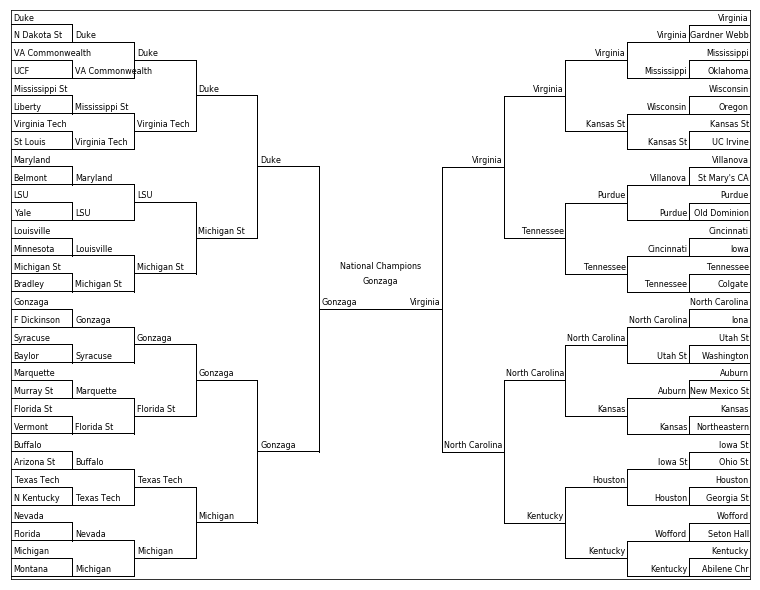

In [38]:
# import lines and set figures to show inline
import matplotlib.lines as mlines
%matplotlib inline

# make a figure and axes
fig, ax = plt.subplots(figsize = (11,8.5))
fig.tight_layout()

# turn off tick marks and labels
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')

# change the default font size
plt.rcParams.update({'font.size': 8})

# set initial x and y positions for round 1
xL = 0
xR = 1
yL = .995
yR = .995

# loop over the rounds
for r in [1,2,3,4,5,6]: #range(len(rounds_dict)):

    # set current round and length
    rcurr = 'round' + str(r)
    lcurr = len(rounds_dict[rcurr])

    
    # place teams on left side
    for t in range(lcurr//2):
        # write team names
        tid = rounds_dict[rcurr][t]
        tname = teams.loc[teams['TeamID'] == tid]['TeamName'].item()
        ax.text(xL+(1/256), yL, tname, horizontalalignment='left', verticalalignment='top')

        # draw horizontal bracket lines
        yht = (1/48) + (1/(lcurr/2))
        line1 = mlines.Line2D([xL, xL+(1/12)], [yL-(1/50), yL-(1/50)], lw=1, color='k')
        ax.add_line(line1)
        
        # draw vertical connector lines for every other team
        if (t%2 == 0) & (r < 6):
            line2 = mlines.Line2D([xL+(1/12), xL+(1/12)], [yL-(1/48), yL-(yht)], lw=1, color='k')
            ax.add_line(line2)
        
        # adjust y position for the next team
        yL -= 1/(lcurr//2)
    

    # place teams on right side
    for t in range(lcurr//2, lcurr):
        # write team names
        tid = rounds_dict[rcurr][t]
        tname = teams.loc[teams['TeamID'] == tid]['TeamName'].item()
        ax.text(xR-(1/512), yR, tname, horizontalalignment='right', verticalalignment='top')
        
        # draw horizontal bracket lines
        yht = (1/48) + (1/(lcurr/2))
        line1 = mlines.Line2D([xR, xR-(1/12)], [yR-(1/48), yR-(1/48)], lw=1, color='k')
        ax.add_line(line1)
        
        # draw vertical connector lines for every other team
        if (t%2 == 0) & (r < 6):
            line2 = mlines.Line2D([xR-(1/12), xR-(1/12)], [yR-(1/48), yR-(yht)], lw=1, color='k')
            ax.add_line(line2)
        
        # adjust y position for next team
        yR -= 1/(lcurr//2)
    
    # change x and y positions for the next round
    xL += 1/12
    xR -= 1/12
    yL = .995-(1/(lcurr//2))
    yR = .995-(1/(lcurr//2))

# place winning team in center
tid = rounds_dict['round7'][0]
tname = teams.loc[teams['TeamID'] == tid]['TeamName'].item()
ax.text(0.5,0.55, 'National Champions', horizontalalignment='center', verticalalignment='center')
ax.text(0.5,0.525, tname, horizontalalignment='center', verticalalignment='center');

